In [75]:
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve
from sklearn import metrics
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
from skimage import io, transform
import os
import random
import pandas as pd


SMALL_SIZE = 22
MEDIUM_SIZE = 24
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines', linewidth=5)

    

In [ ]:
# Draw exaple image grid
files = os.listdir('/home/simon/Pictures/M009L')
print(files)
images = [io.imread(os.path.join('/home/simon/Pictures/M009L', f)) for f in files]
random.shuffle(images)

fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, images[:4]):
    # Iterating over the grid returns the Axes.
    im = transform.resize(im, (800, 800))
    ax.imshow(im)

plt.show()

Number of attention weights: 1044, Number of Batches: 18


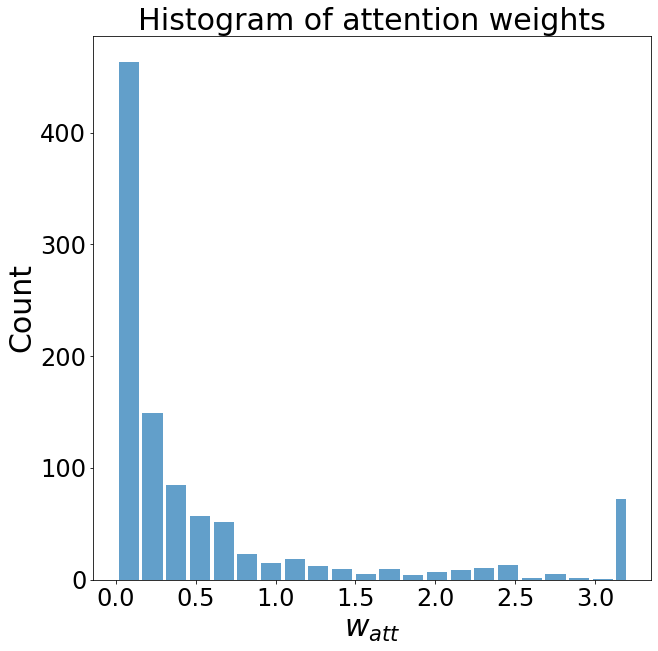

In [167]:
# Histogram of attention weights
def reject_outliers(data, m=2):
    return data[data - np.mean(data) < m * np.std(data)]

def get_normalized_weights(df, col_idx = 5, mode='extend'):
    acc_attention_weights = []
    for row in df.itertuples():
        weights = eval(row[col_idx])
        weights = [w * len(weights) for w in weights]
        if mode == 'extend':
            acc_attention_weights.extend(weights)
        else:
            acc_attention_weights.append(weights)
    
    print(f'Number of attention weights: {len(acc_attention_weights) if mode=="extend" else len(acc_attention_weights[0])},'
          f' Number of Batches: {len(df_att)}')
    att_w = np.array(acc_attention_weights)
    return att_w
#att_w = reject_outliers(att_w, m=2)

num_bins = 150
upper_value = 3.2
#df_att = pd.read_csv('/home/simon/Code/krepelschrofen/MasterThesis/docs/training_mil_avg_0.744_0.700.csv')
df_att = pd.read_csv('~/Code/krepelschrofen/pad_classification/20201210_1635_fold5_PAD/49_last_pad_model_0.615.csv')
att_w = get_normalized_weights(df_att)

_, bin_edges = np.histogram(att_w, bins=num_bins)
bin_edges = [b for b in bin_edges if b < upper_value] + [upper_value]
att_w[att_w >= np.ceil(upper_value)] = upper_value

fig = plt.figure(figsize=(10., 10.))
plt.hist(att_w, density=False, alpha=0.7, rwidth=0.85, bins=bin_edges)
#mn, mx = plt.xlim()
#kde_xs = np.linspace(mn, mx, 301)
#kde = st.gaussian_kde(att_w)
#plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
plt.ylabel('Count')
plt.xlabel('$w_{att}$')
plt.title("Histogram of attention weights")
plt.savefig(os.path.join('/home/simon/Pictures', 'Histogram of attention weights.png'))

[(3.7183357402682304, ['pos/G004R_23.png']), (3.8643173575401306, ['pos/G007L_424.png']), (4.43525755405426, ['pos/G007L_174.png']), (4.464231252670288, ['pos/G007L_586.png'])] 993


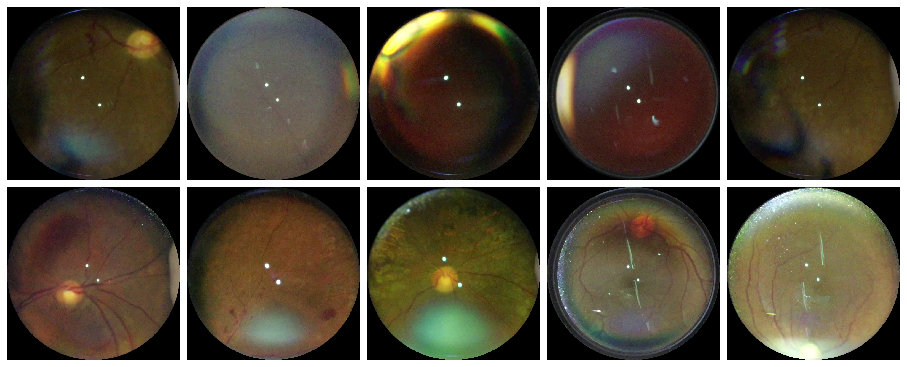

In [236]:
# Attention weight gallery
img_path = '/home/simon/Pictures/val'
num_images = 5

def get_weighted_filtered_image_list(labels_df, conf_th = 0.01, dev_th = 2):
    weighted_samples = []
    for row in labels_df.itertuples():
        weights = eval(row[5])
        frames = eval(row[6])
        confidence = row[4]
        if conf_th <= confidence <= (1. - conf_th):
            continue
        weights = [w * len(weights) for w in weights]
        weighted_samples.extend(list(zip(weights, frames)))

    mean, std = np.mean(np.array([w for w, _ in weighted_samples])), np.std(np.array([w for w, _ in weighted_samples])) 
    weighted_samples = sorted(weighted_samples, key=lambda d: d[0])
    weighted_samples = [sample for sample in weighted_samples if sample[0] - mean < dev_th * std]

    print(weighted_samples[-4:], len(weighted_samples))
    return weighted_samples

def draw_image_grid(base, images, rows_cols=(2, 2)):
    fig = plt.figure(figsize=(16., 16.))
    grid = ImageGrid(fig, 111, rows_cols, axes_pad=0.1) # similar to subplot(111)

    for ax, im in zip(grid, images[:rows_cols[0]*rows_cols[1]]): # Iterating over the grid returns the Axes
        img = io.imread(os.path.join(base, im))
        img = transform.resize(img, (800, 800))
        ax.axis('off')
        ax.imshow(img)
    plt.show()
    
random.seed(1)
w_samples = get_weighted_filtered_image_list(df_att, dev_th = 1000, conf_th=0.01)
sample_iv = int(len(w_samples) * 0.1)
draw_image_grid(img_path, [p[0] for _, p in (random.sample(w_samples[:sample_iv], num_images) + random.sample(w_samples[-sample_iv:], num_images))], rows_cols=(2, num_images))
#draw_image_grid(img_path, [p[0] for _, p in w_samples[-4:]], rows_cols=(1, 4))


ROC AUC:  0.7333333333333334


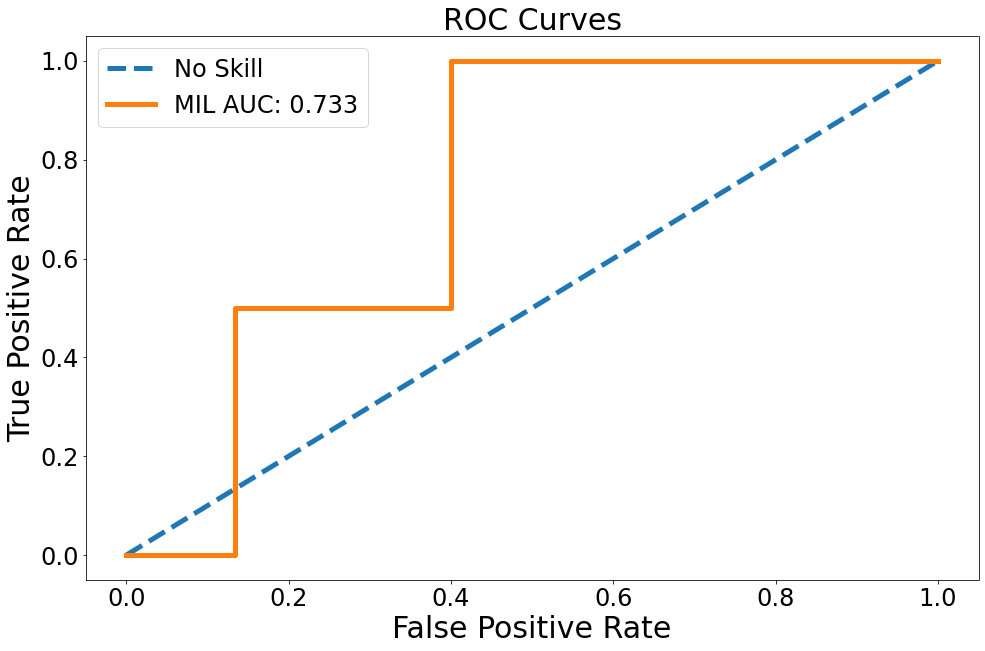

In [172]:
# calc ROC AUC

def get_roc_values(path, no_skill = False):
    df_att = pd.read_csv(path)
    df_val = df_att.iloc[:, :4]
    df_val = df_val.groupby(['eye_id']).mean().reset_index()   # Average across bags
    ns_auc, ns_fpr, ns_tpr = 0, 0, 0

    if no_skill:
        ns_probs = [0 for _ in range(len(df_val))]
        ns_auc = roc_auc_score(df_val['label'], ns_probs)
        ns_fpr, ns_tpr, _ = roc_curve(df_val['label'], ns_probs)
    
    lr_auc = roc_auc_score(df_val['label'], df_val['probability'])
    lr_fpr, lr_tpr, ths = roc_curve(df_val['label'], df_val['probability'])
    
    print('ROC AUC: ', lr_auc)
    return ((lr_auc, ns_auc), lr_fpr, lr_tpr, ns_fpr, ns_tpr) if no_skill else ((lr_auc, None), lr_fpr, lr_tpr, None, None)


def get_prroc_values(path, no_skill = False):
    df_att = pd.read_csv(path)
    df_val = df_att.iloc[:, :4]
    df_val = df_val.groupby(['eye_id']).mean().reset_index()   # Average across bags
    precision, recall, ths = precision_recall_curve(df_val['label'], df_val['probability'])
    pr_auc = metrics.auc(recall, precision)
    ns = 0
    
    if no_skill:
        ns = len(df_val['label'][df_val['label']==1]) / len(df_val['label'])
    
    print('PR AUC: ', pr_auc)
    return (pr_auc, precision, recall, ns if no_skill else None)


auc_mil, lr_fpr, lr_tpr, ns_fpr, ns_tpr = get_roc_values('/home/simon/Code/krepelschrofen/pad_classification/20201210_1703_fold6_PAD/49_last_pad_model_0.5.csv', no_skill=True)
#get_roc_values('../docs/training_mil_avg_0.744_0.700.csv', no_skill=True)
#auc_nopre, lr_fpr_nopre, lr_tpr_nopre, _, _ = get_roc_values('../docs/training_mil_avg_svm_nopretraining.csv')
#auc_nosvm, lr_fpr_nosvm, lr_tpr_nosvm, _, _ = get_roc_values('../docs/training_mil_avg_nosvm_pretrained.csv')


plt.figure(figsize=(16, 10))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label=f'MIL AUC: {auc_mil[0]:0.3f}')
#plt.plot(lr_fpr_nopre, lr_tpr_nopre, linestyle='-.', marker='.', label=f'w/o KAGGLE AUC: {auc_nopre[0]:0.3f}', linewidth=4)
#plt.plot(lr_fpr_nosvm, lr_tpr_nosvm, linestyle='-.', marker='.', label=f'w/o SVM AUC: {auc_nosvm[0]:0.3f}', linewidth=4)
plt.xlabel('False Positive Rate') # axis labels
plt.ylabel('True Positive Rate')
# plt.title(f'ROC AUC = {lr_auc:0.3f}')
plt.title(f'ROC Curves')
plt.legend() # show the legend
plt.savefig('/home/simon/Pictures/pad_mil_roc_curve_fold6')

PR AUC:  0.8740079365079365
Precision recall AUC:  0.8740079365079365


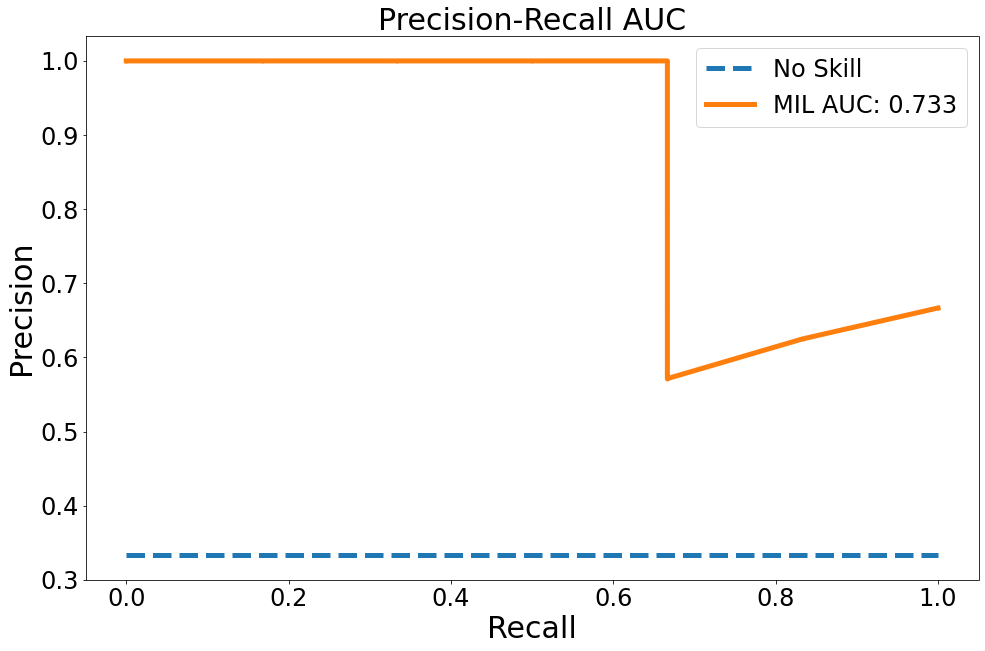

In [171]:
# Precision-recall curve

pr_auc_mil, pre, rec, ns = get_prroc_values('/home/simon/Code/krepelschrofen/pad_classification/20201210_1635_fold5_PAD/49_last_pad_model_0.615.csv', no_skill=True)
#pr_auc_nopre, pre_nopre, rec_nopre, _ = get_prroc_values('../docs/training_mil_avg_svm_nopretraining.csv')
#pr_auc_nosvm, pre_nosvm, rec_nosvm, _ = get_prroc_values('../docs/training_mil_avg_nosvm_pretrained.csv')

plt.figure(figsize=(16, 10))
plt.plot([0, 1], [ns, ns], linestyle='--', label='No Skill')
plt.plot(rec, pre, marker='.', label=f'MIL AUC: {auc_mil[0]:0.3f}')
#plt.plot(rec_nopre, pre_nopre, linestyle='-.', marker='.', linewidth=4, label=f'w/o KAGGLE AUC: {pr_auc_nopre:0.3f}')
#plt.plot(rec_nosvm, pre_nosvm, linestyle='-.', marker='.', linewidth=4, label=f'w/o SVM AUC: {pr_auc_nosvm:0.3f}')

plt.xlabel('Recall') # axis labels
plt.ylabel('Precision')
plt.title(f'Precision-Recall AUC')
#plt.title(f'Precision-Recall AUC = {pr_auc:0.3f}')
plt.legend() # show the legend

print('Precision recall AUC: ', pr_auc_mil)

Number of attention weights: 58, Number of Batches: 19
     eye_id  label  prediction  probability  \
0   BF0553R      1         1.0     0.864903   
1   FH0350R      0         0.0     0.208893   
2   FH0350L      0         0.0     0.226140   
3   GN0641R      0         0.0     0.018866   
4   GN0641L      0         0.0     0.002472   
5   KA0307L      0         0.0     0.003400   
6   KM0946R      0         1.0     0.886848   
7   KM0946L      0         1.0     0.960231   
8   LC2306L      1         0.0     0.147471   
9   LC2306R      1         1.0     0.654181   
10  OR1248R      0         0.0     0.002702   
11  OR1248L      0         0.0     0.315014   
12  PH0846R      0         0.0     0.276372   
13  PH0846L      0         0.0     0.019400   
14  SM0331R      0         0.0     0.001271   
15  SM0331L      0         0.0     0.007509   
16  UM1257R      0         0.0     0.000767   
17  UM1257L      0         0.0     0.000103   
18  WE0551L      1         0.0     0.023552   

    

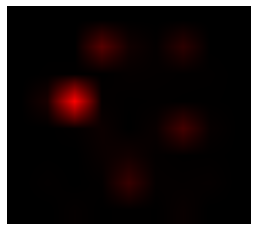

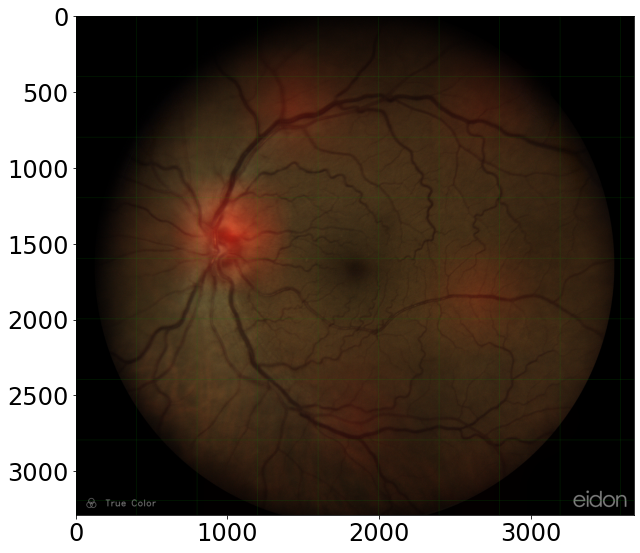

In [166]:
df_att = pd.read_csv('/home/simon/Code/krepelschrofen/pad_classification/20201210_1703_fold6_PAD/49_last_pad_model_0.5.csv')
example_examination = 'OR1248L'
example_idx = df_att[df_att['eye_id'] == example_examination].index
example_img = io.imread(os.path.join('/home/simon/Data/pAVK_dataset/Color_anonym/', example_examination + '.jpg'))

dx, dy = 399, 399
grid_color = [0, 255, 0]
example_img[:,::dy,:] = grid_color
example_img[::dx,:,:] = grid_color

plt.axis('off')
plt.imshow(example_img)

df_att['prediction'] = df_att['prediction'].apply(lambda d: eval(d)[0])
att_w = get_normalized_weights(df_att, mode='append')
print(df_att.head(20))
weights = att_w[example_idx]
weights = (weights - np.min(weights)) / (np.max(weights) - np.min(weights))
count, seg_count = 0, 0
for y in range(0, example_img.shape[0], 399):
    for x in range(0, example_img.shape[1], 399):
        segment = example_img[y:y+399, x:x+399]
        if segment.shape[0] * segment.shape[1] != 399**2:
            continue
        count_non_black_px = cv2.countNonZero(cv2.cvtColor(segment, cv2.COLOR_BGR2GRAY))
        if count_non_black_px / 399**2 < 0.5:
            count += 1
            weights = np.insert(weights, seg_count, 0.0)
        seg_count += 1

print(f'Inserted attention weights for {count} black segements')

att_heatmap = weights.reshape((example_img.shape[0] // 399, example_img.shape[1] // 399))
att_heatmap_scale = cv2.resize(att_heatmap, (example_img.shape[1], example_img.shape[0]))
colormap = plt.get_cmap('viridis')
att_heatmap_scale = (att_heatmap_scale * 256).astype(np.uint8)
att_heatmap_scale = cv2.merge((att_heatmap_scale, np.zeros_like(att_heatmap_scale), np.zeros_like(att_heatmap_scale)))
#att_heatmap_scale = cv2.cvtColor(att_heatmap_scale, cv2.COLOR_GRAY2RGB)
plt.imshow(att_heatmap_scale)
#plt.imshow(att_heatmap, cmap='viridis', interpolation='nearest')

fig = plt.figure(figsize=(10., 10.))
fin = cv2.addWeighted(att_heatmap_scale, 0.5, example_img, 0.5, 0)
plt.imshow(fin)
plt.savefig(os.path.join('/home/simon/Pictures/', example_examination + '_visualized_attention_weights.png'))
